In [1]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('Data/Book1.csv')
lon = np.loadtxt('Data/L1_lon.txt')
depths = np.loadtxt('Data/L1_z.txt')

# Make sure depths length matches the number of rows in df
if len(depths) != df.shape[0]:
    depths = depths[:df.shape[0]]  # Adjusting depth array to match df rows if necessary

# Define the target longitudes and find closest indices
target_longitudes = [-125.147903, -125.405296]

def find_closest_index(array, value):
    index = np.abs(array - value).argmin()
    return index

indices = [find_closest_index(lon, longitude) for longitude in target_longitudes]

# Extract the velocity profiles for the specified longitudes
velocity_profile_hys14 = df.iloc[:, indices[0]]
velocity_profile_hysb1 = df.iloc[:, indices[1]]

# Create a new DataFrame with depth and the extracted velocity profiles
velocity_profile_df = pd.DataFrame({
    'Depth': depths,
    'VpHYS14': velocity_profile_hys14,
    'VpHYSB1': velocity_profile_hysb1,
    'VsHYSB1': velocity_profile_hysb1/2.9,
    'VsHYS14': velocity_profile_hys14/2.2,  
})
velocity_profile_df['Thickness'] = velocity_profile_df['Depth'].diff()
velocity_profile_df['Thickness'].iloc[0] = 0

# Print and save the DataFrame if necessary
print(velocity_profile_df)
velocity_profile_df.to_csv('extracted_velocity_profiles.csv', index=False)


     Depth  VpHYS14  VpHYSB1   VsHYSB1   VsHYS14  Thickness
0      0.0    1.810    1.945  0.670690  0.822727        0.0
1      0.1    1.819    1.974  0.680690  0.826818        0.1
2      0.2    1.965    2.000  0.689655  0.893182        0.1
3      0.3    2.188    2.041  0.703793  0.994545        0.1
4      0.4    2.209    2.088  0.720000  1.004091        0.1
..     ...      ...      ...       ...       ...        ...
101   37.5    7.989    8.011  2.762414  3.631364        0.5
102   38.0    7.992    8.015  2.763793  3.632727        0.5
103   38.5    7.996    8.018  2.764828  3.634545        0.5
104   39.0    7.999    8.021  2.765862  3.635909        0.5
105   39.5    8.002    8.024  2.766897  3.637273        0.5

[106 rows x 6 columns]


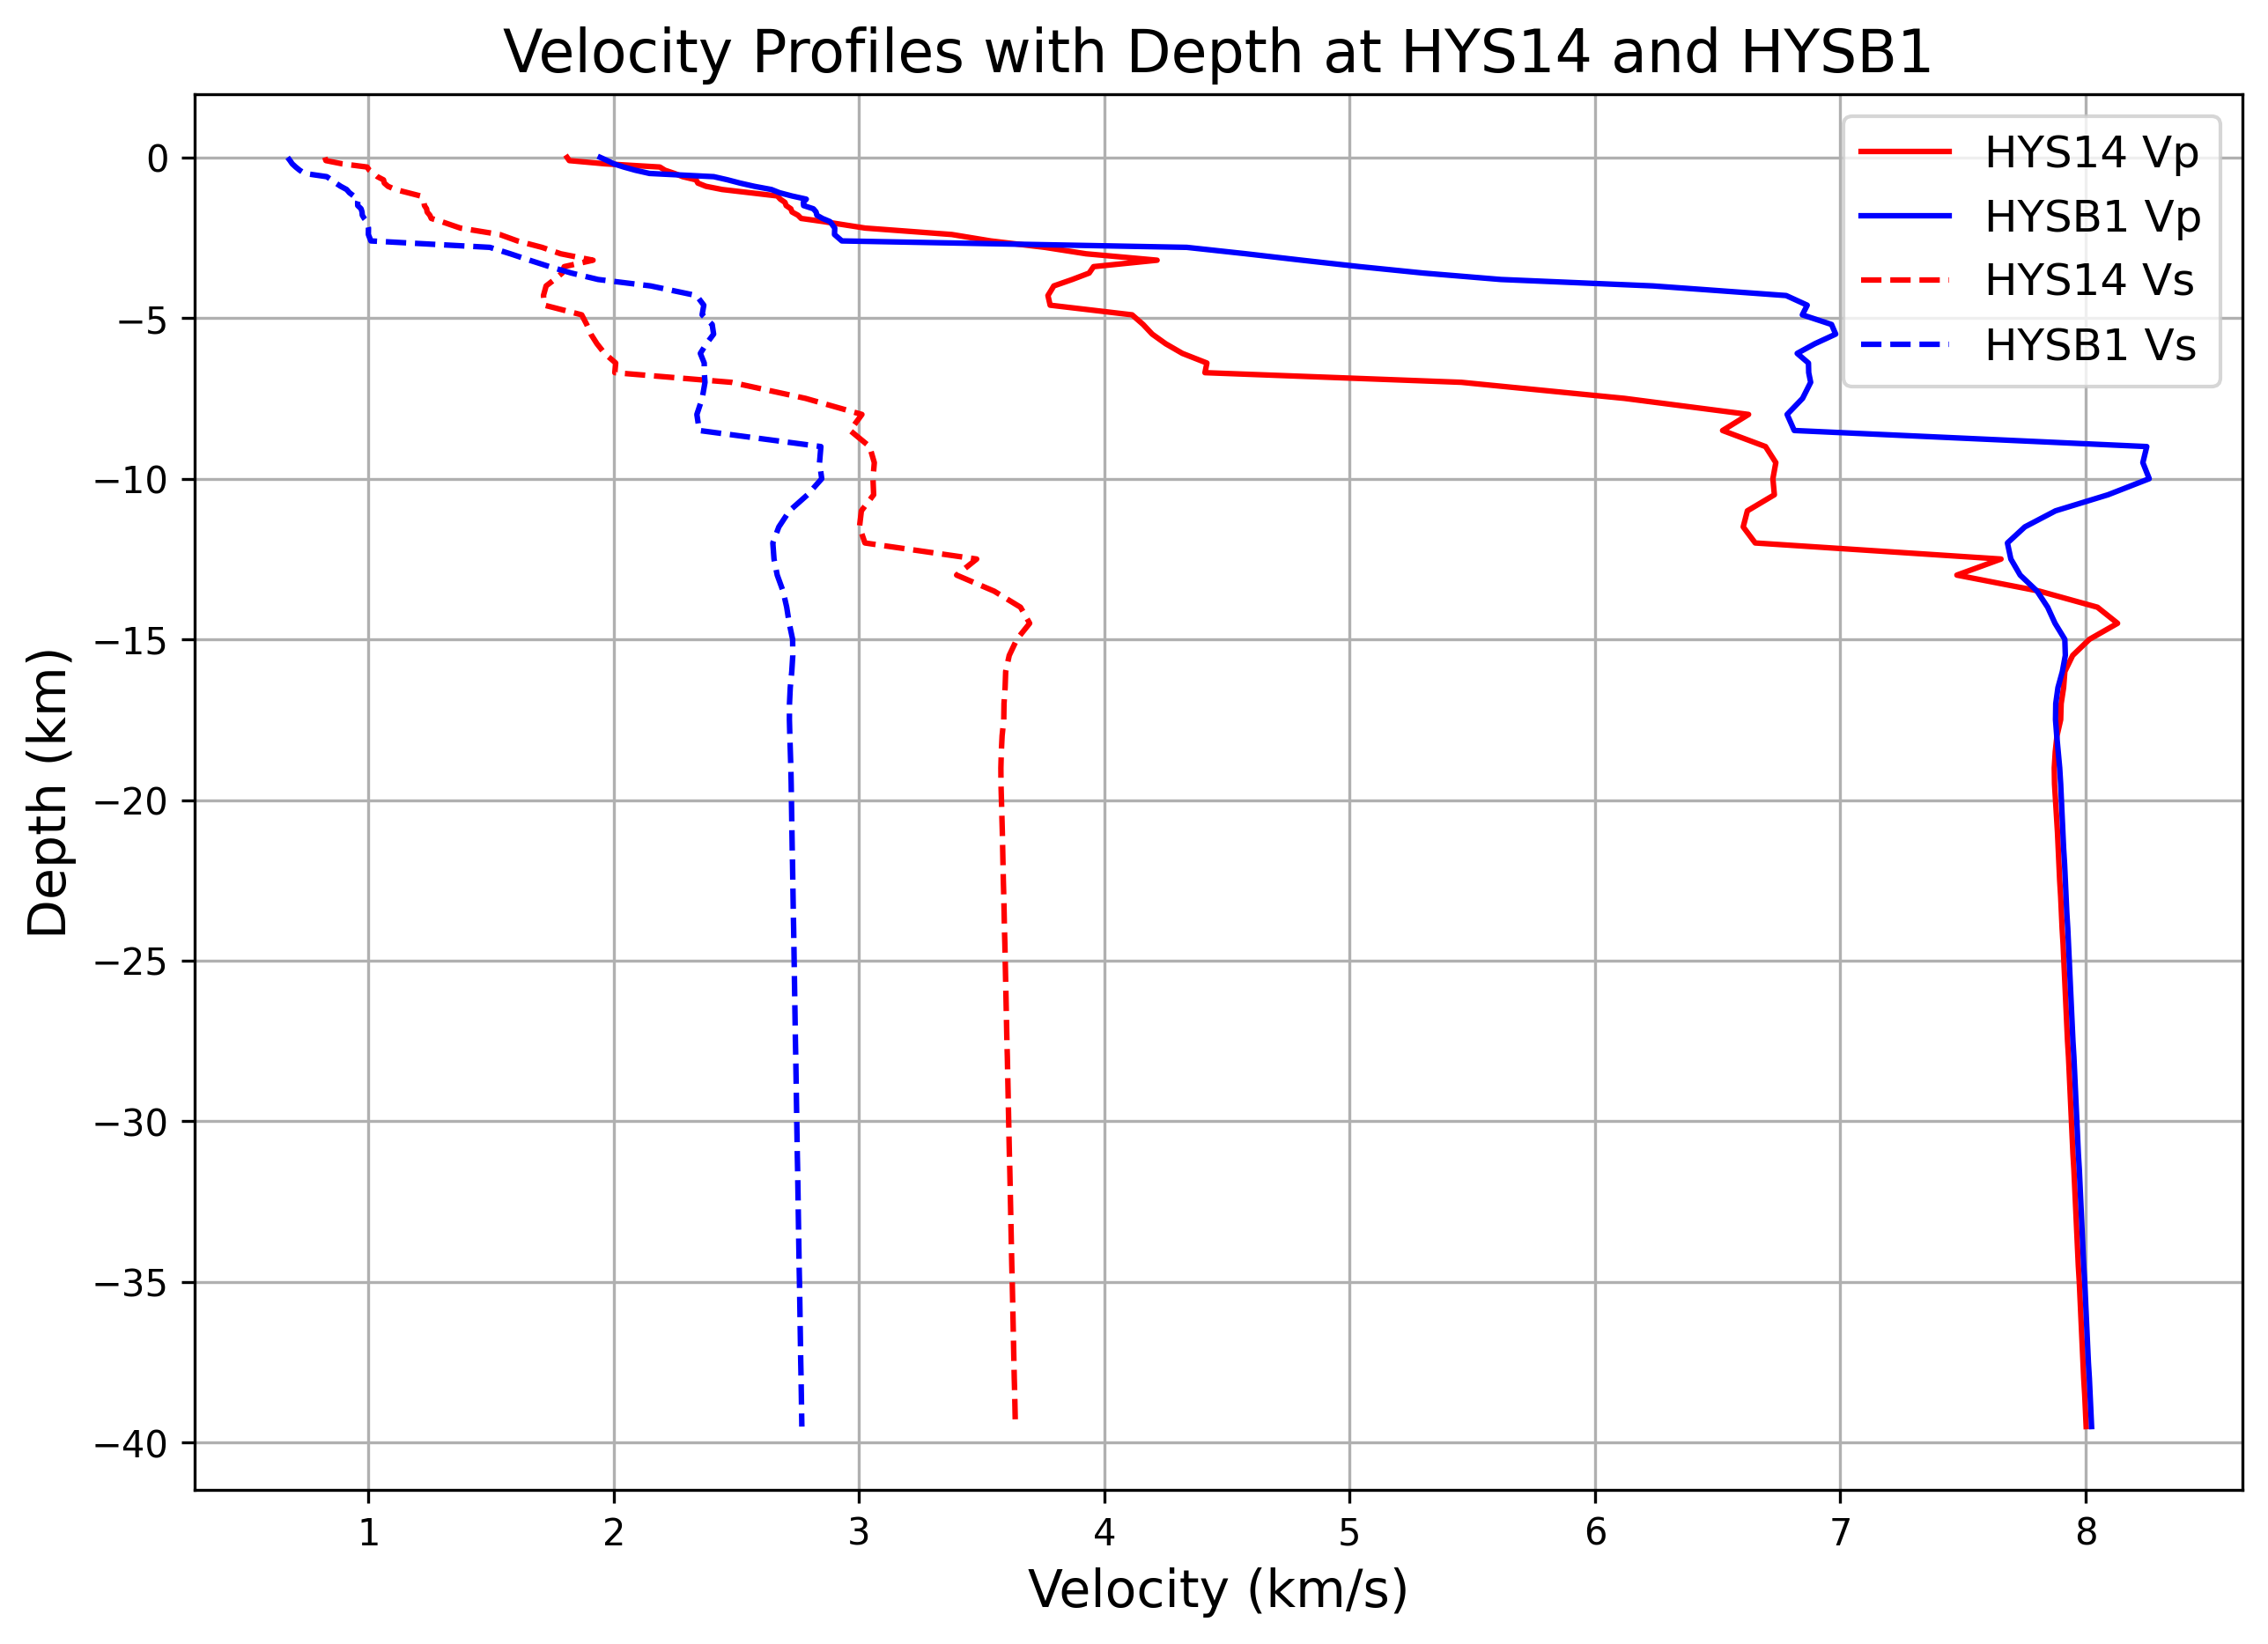

In [2]:
import matplotlib.pyplot as plt

# Assuming the DataFrame 'velocity_profile_df' is already loaded and contains the required data
plt.figure(figsize=(10, 7),dpi=300)
plt.plot(velocity_profile_df['VpHYS14'], -velocity_profile_df['Depth'], label='HYS14 Vp', linestyle='-', color='red')
plt.plot(velocity_profile_df['VpHYSB1'], -velocity_profile_df['Depth'], label='HYSB1 Vp', linestyle='-', color='blue')
plt.plot(velocity_profile_df['VsHYS14'], -velocity_profile_df['Depth'], label='HYS14 Vs', linestyle='--', color='red')
plt.plot(velocity_profile_df['VsHYSB1'], -velocity_profile_df['Depth'], label='HYSB1 Vs', linestyle='--', color='blue')

plt.xlabel('Velocity (km/s)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
plt.title('Velocity Profiles with Depth at HYS14 and HYSB1', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [41]:
import numpy as np

# Extract the relevant columns from the DataFrame
thickness = velocity_profile_df['Thickness'].values
VpHYS14 = velocity_profile_df['VpHYSB1'].values
VsHYS14 = velocity_profile_df['VsHYSB1'].values

# Define a constant density value (in g/cm^3)
density = 2.2

# Combine the arrays into a numpy array with the specified structure
velocity_model = np.column_stack((thickness, VpHYS14, VsHYS14, np.full(len(thickness), density)))
velocity_model = velocity_model[1:, :]

# Print the velocity model to check the result
print("Velocity model")
print("# thickness, Vp, Vs, density")
print("# km, km/s, km/s, g/cm3")
print(velocity_model)

Velocity model
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
[[0.1        1.974      0.68068966 2.2       ]
 [0.1        2.         0.68965517 2.2       ]
 [0.1        2.041      0.7037931  2.2       ]
 [0.1        2.088      0.72       2.2       ]
 [0.1        2.146      0.74       2.2       ]
 [0.1        2.408      0.83034483 2.2       ]
 [0.1        2.465      0.85       2.2       ]
 [0.1        2.515      0.86724138 2.2       ]
 [0.1        2.573      0.88724138 2.2       ]
 [0.1        2.643      0.91137931 2.2       ]
 [0.1        2.676      0.92275862 2.2       ]
 [0.1        2.726      0.94       2.2       ]
 [0.1        2.785      0.96034483 2.2       ]
 [0.1        2.773      0.9562069  2.2       ]
 [0.1        2.774      0.95655172 2.2       ]
 [0.1        2.814      0.97034483 2.2       ]
 [0.1        2.825      0.97413793 2.2       ]
 [0.1        2.828      0.97517241 2.2       ]
 [0.1        2.851      0.98310345 2.2       ]
 [0.1        2.882      0.9937931  2.2 

In [42]:
from disba import PhaseSensitivity
import numpy as np

# Frequency to period conversion
frequencies = np.array([0.1, 0.3, 0.5, 1.0, 3.0, 5.0])  # Correct the frequency range and increments
periods = 1 / frequencies  # Convert frequency to period

# Assuming velocity_model is defined somewhere in your code
ps = PhaseSensitivity(*velocity_model.T)
parameters = ["thickness", "velocity_p", "velocity_s", "density"]
skr = [ps(period, mode=0, wave="rayleigh", parameter=parameter) for period in periods for parameter in parameters]  # Nested loop for clarity
skl = [ps(period, mode=0, wave="love", parameter=parameter) for period in periods for parameter in parameters]


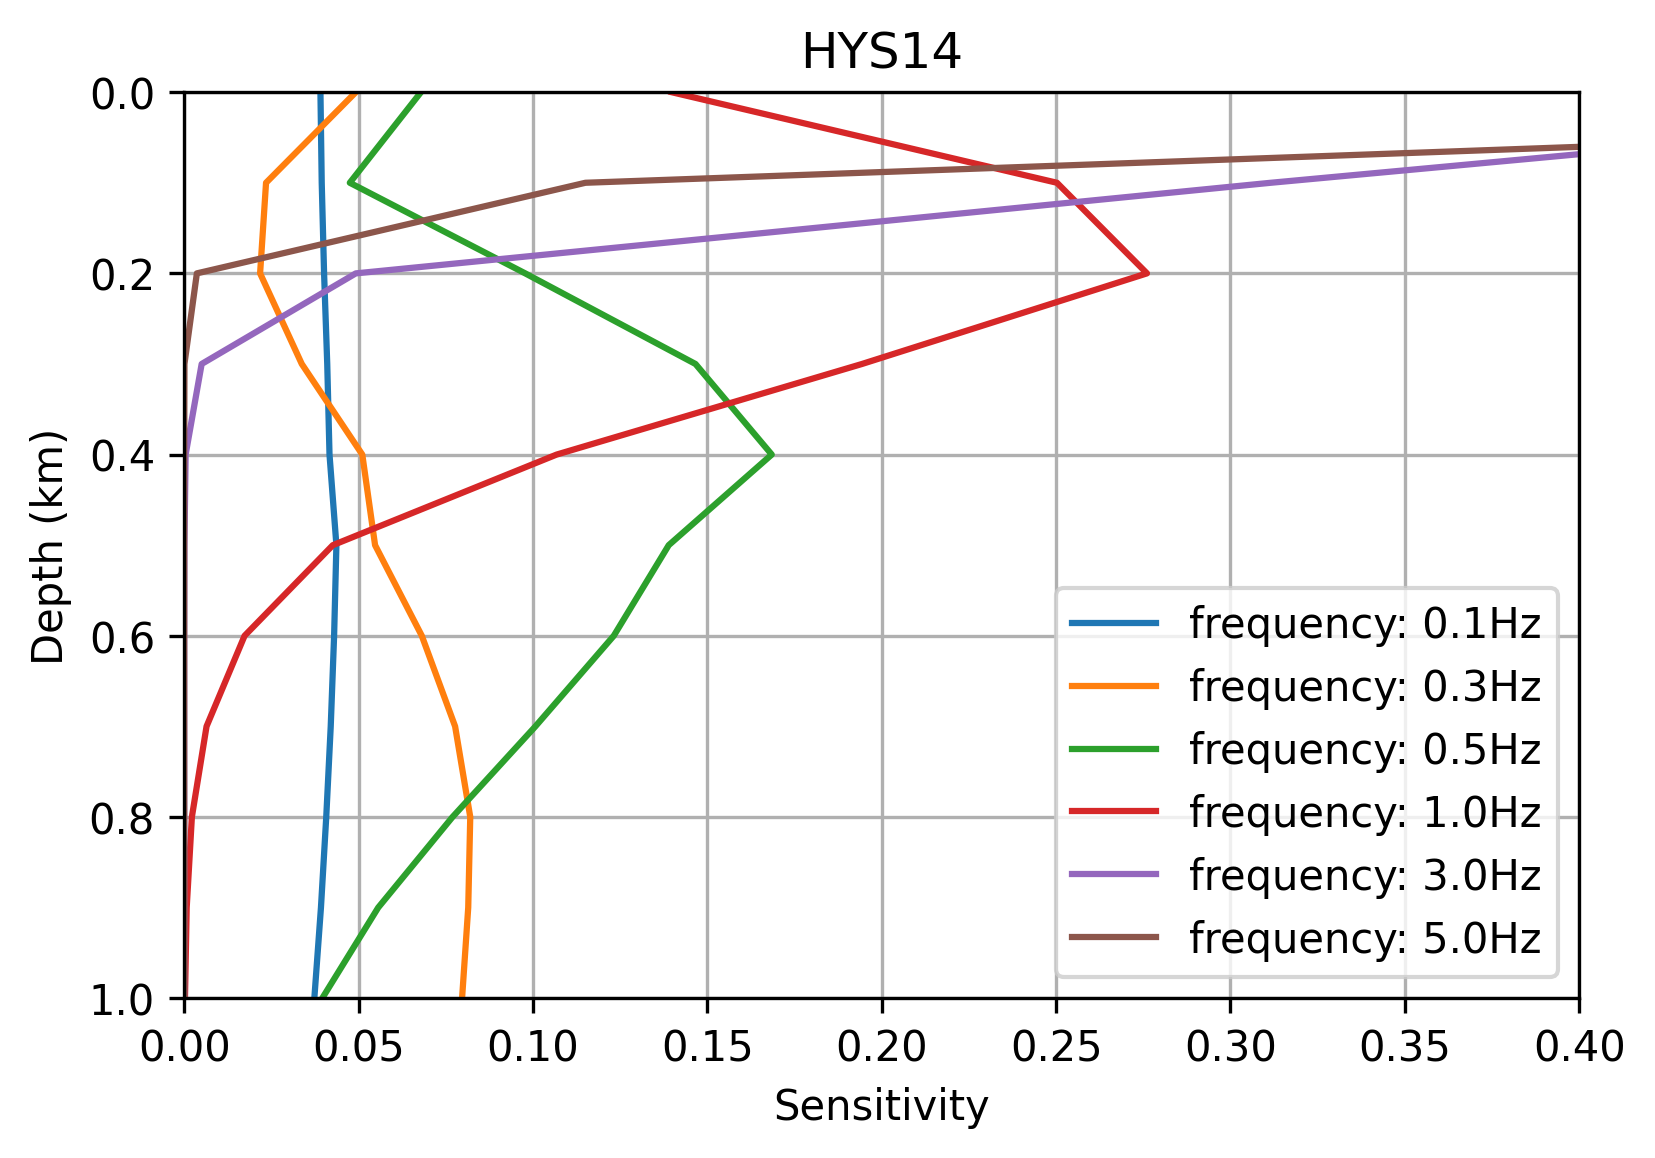

In [43]:
plt.figure(figsize=(6, 4),dpi=300)
for skrs in skr:
    if skrs.parameter == 'velocity_s':
        plt.plot(skrs.kernel, skrs.depth, label=f'frequency: {1/skrs.period}Hz')
plt.xlabel('Sensitivity')
plt.ylabel('Depth (km)')
plt.title('HYS14')
plt.legend()
plt.xlim([0.0,0.4])
plt.ylim([0,1])
plt.grid(True)
plt.gca().invert_yaxis()  # Invert the y-axis to show depth increasing downwards
plt.show()

In [44]:
import numpy as np
from scipy.integrate import simps

# Dictionary to map frequency --> (depth array, sensitivity array)
freq_vs_sensitivity = {}

# 1) Collect depth/sensitivity for each frequency (Rayleigh, velocity_s)
for skrs in skr:
    if skrs.parameter == 'velocity_s':
        freq = 1.0 / skrs.period
        freq_vs_sensitivity[freq] = (skrs.depth, skrs.kernel)

# 2) Compute Hc for each frequency using Simpson's rule
hc_values = {}
for freq, (depth, kernel) in freq_vs_sensitivity.items():
    # Integrate f(z)*z and f(z) separately
    numerator = simps(kernel * depth, depth)
    denominator = simps(kernel, depth)

    # Avoid division by zero
    hc = numerator / denominator if denominator != 0 else np.nan
    hc_values[freq] = hc

# 3) Print out results
print("\n--- Characteristic Depth (Hc) for Each Frequency ---")
for freq in sorted(hc_values.keys()):
    print(f"Frequency: {freq:.2f} Hz, Hc: {hc_values[freq]:.4f} km")


--- Characteristic Depth (Hc) for Each Frequency ---
Frequency: 0.10 Hz, Hc: 8.5786 km
Frequency: 0.30 Hz, Hc: 1.1141 km
Frequency: 0.50 Hz, Hc: 0.5470 km
Frequency: 1.00 Hz, Hc: 0.2259 km
Frequency: 3.00 Hz, Hc: 0.0770 km
Frequency: 5.00 Hz, Hc: 0.0365 km
